In [1]:
import pickle

from hparams import HParams
from hps import Hyperparams
from vae import VAE

from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.manifold import TSNE
import seaborn as sns
import nltk
from nltk.corpus import stopwords
import string
# from wordcloud import WordCloud

import numpy as np
import os
import glob
from os.path import join as opj
import h5py  
import matplotlib.pyplot as plt
import pandas as pd
import nibabel as nib
from scipy.io import loadmat
import torch
from torch.utils.data import Dataset, Subset, DataLoader
import json
from PIL import Image
# from diffusers import VersatileDiffusionPipeline
# from diffusers import VersatileDiffusionDualGuidedPipeline
from diffusers.models import AutoencoderKL, Transformer2DModel, UNet2DConditionModel
# from versatile_diffusion_dual_guided import VersatileDiffusionDualGuidedPipeline
from versatile_diffusion_dual_guided_fake_images import VersatileDiffusionDualGuidedFromCLIPEmbeddingPipeline
from autoencoder import *
from torchsummary import summary
import torchvision
import tqdm
from sklearn.linear_model import Ridge
import pickle
import wandb


from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

from diffusers.utils import (
    randn_tensor,
)
from decoding import *

# from yellowbrick.cluster import KElbowVisualizer

/home/matteo/anaconda3/envs/deep/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class NSDDataset(Dataset):
    

    
    def __init__(self, fmri_data,imgs_data=None,caption_data=None,transforms=None):
        self.fmri_data=fmri_data
        if imgs_data is not None:
            self.imgs_data=np.load(imgs_data).astype(np.uint8)
        else:
            self.imgs_data=None
        if caption_data is not None:
            self.caption_data=np.load(caption_data,allow_pickle=True)
        else:
            self.caption_data=None
        self.transforms=transforms
        
    def __len__(self):
        return  len(self.fmri_data)
    
    def __getitem__(self,idx):
        fmri=torch.tensor(self.fmri_data[idx])
        
        if self.imgs_data is not None:

        
            img=Image.fromarray(self.imgs_data[idx])

            if self.transforms:
                img=self.transforms(img)
        else:
            img=""
        if self.caption_data is not None:
            caption=self.caption_data[idx] #cambiare se ne voglio altre
        else:
            caption=""
        
        return fmri,img,caption


In [3]:
sub=f"subj0{1}"
subj_path=opj("/home/matteo/explore_NSD_MNI","models",sub)

god_subj="GOD_1"
base_dir=opj("god_aligned",god_subj)

x_train=opj(base_dir,"aligned_source_train.npy")
x_test=np.load(opj(base_dir,"aligned_source_test.npy"))
x_imagery=np.load(opj(base_dir,"aligned_source_imagery.npy"))

y_train=opj(base_dir,"y_train.npy")
y_test=opj(base_dir,"y_test.npy")

#average activations

labels=np.load(opj(base_dir,"labels_test.npy"))
image_labels=np.load(opj(base_dir,"labels_imagery.npy"))

x_test_avg=[]
for i in range(50):
    x_test_avg.append(x_test[np.where(labels==i)[0]].mean(0))
    
x_test_avg=np.array(x_test_avg)

x_imagery_avg=[]
for i in range(50):
    x_imagery_avg.append(x_imagery[np.where(image_labels==i)[0]].mean(0))
    
x_imagery_avg=np.array(x_imagery_avg)


#load images for averages
y_test_avg=opj(base_dir,"y_test_avg.npy")





# y_imagery=opj(base_dir,"y_imagery.npy")

# captions_train=opj(base_dir,"train_captions.npy")
# captions_test=opj(base_dir,"test_captions.npy")
# captions_align=opj(base_dir,"align_captions.npy")


BS=32
tr=torchvision.transforms.ToTensor()
# train_dataset=NSDDataset(x_train,y_train,None,transforms=tr)
test_dataset=NSDDataset(x_test_avg,y_test_avg,None,transforms=tr)
imagery_dataset=NSDDataset(x_imagery_avg,None,None,transforms=tr)


# train_dataloader=DataLoader(train_dataset,BS,shuffle=False)
test_dataloader=DataLoader(test_dataset,BS,shuffle=False)
imagery_dataloader=DataLoader(imagery_dataset,BS,shuffle=False)

# x_train=x_train[:1000]


##lavorare qui


In [4]:
# np.where(image_labels==i)[0]
x,y,c=next(iter(test_dataloader))

In [5]:
x.shape

torch.Size([32, 14197])

In [6]:
## get decoder

subj_path=opj("/home/matteo/explore_NSD_MNI","models",sub)
brain_decoder=BrainDiffuserPretrainedDecoder(subj_path=subj_path,device="cuda:0")

Loading pretrained deep learning backbones


Fetching 17 files: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 59868.32it/s]


Loading pretrained brain to feature models
loading brain to latent models


/home/matteo/anaconda3/envs/deep/lib/python3.9/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator Ridge from version 1.2.2 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


loading brain to img embeddings models
loading brain to txt embeddings models
loading adjust values
loading predicted values for adjusting


In [29]:
x,y,c=next(iter(test_dataloader))

# x = (x -torch.tensor(x_test_avg).mean())/torch.tensor(x_test_avg).std()

x= (x-brain_decoder.train_fmri_mean)/brain_decoder.train_fmri_std
x= torch.nan_to_num(x)

start_idx_img=0

img,gss=brain_decoder.decode(x[start_idx_img:start_idx_img+2],scale=False,use_latents=True)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 77/77 [00:00<00:00, 234.07it/s]
/home/matteo/anaconda3/envs/deep/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


tensor(0.8039)
[INFO] Final reconstrution 1/2


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:13<00:00,  2.83it/s]


[INFO] Final reconstrution 2/2


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:13<00:00,  2.83it/s]


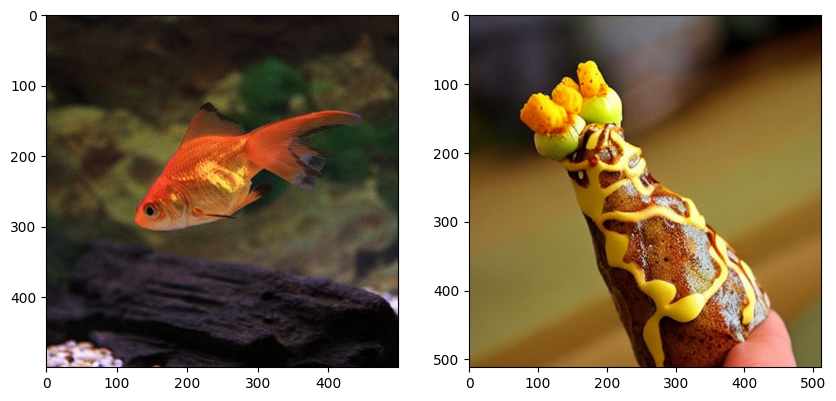

In [30]:
fig,axs=plt.subplots(1,2,figsize=(10,5))
idx=0
axs[0].imshow(y[start_idx_img+idx].permute(1,2,0))
axs[1].imshow(img[idx])


## Imagery

In [135]:
x,y,c=next(iter(imagery_dataloader))

x= (x-brain_decoder.train_fmri_mean)/brain_decoder.train_fmri_std
x= torch.nan_to_num(x)

start_idx_img=0

img,gss=brain_decoder.decode(x[start_idx_img:start_idx_img+20],scale=False,use_latents=True)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 77/77 [00:20<00:00,  3.78it/s]


tensor(0.9922)
[INFO] Final reconstrution 1/20


/home/matteo/anaconda3/envs/deep/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:05<00:00,  6.94it/s]


[INFO] Final reconstrution 2/20


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:05<00:00,  6.94it/s]


[INFO] Final reconstrution 3/20


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:05<00:00,  6.98it/s]


[INFO] Final reconstrution 4/20


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:05<00:00,  6.75it/s]


[INFO] Final reconstrution 5/20


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:05<00:00,  6.87it/s]


[INFO] Final reconstrution 6/20


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:05<00:00,  7.02it/s]


[INFO] Final reconstrution 7/20


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:05<00:00,  6.78it/s]


[INFO] Final reconstrution 8/20


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:05<00:00,  6.76it/s]


[INFO] Final reconstrution 9/20


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:05<00:00,  6.68it/s]


[INFO] Final reconstrution 10/20


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:05<00:00,  6.67it/s]


[INFO] Final reconstrution 11/20


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:05<00:00,  6.67it/s]


[INFO] Final reconstrution 12/20


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:05<00:00,  6.57it/s]


[INFO] Final reconstrution 13/20


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:05<00:00,  6.62it/s]


[INFO] Final reconstrution 14/20


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:05<00:00,  6.45it/s]


[INFO] Final reconstrution 15/20


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:05<00:00,  6.75it/s]


[INFO] Final reconstrution 16/20


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:05<00:00,  6.64it/s]


[INFO] Final reconstrution 17/20


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:05<00:00,  6.68it/s]


[INFO] Final reconstrution 18/20


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:05<00:00,  6.98it/s]


[INFO] Final reconstrution 19/20


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:05<00:00,  6.98it/s]


[INFO] Final reconstrution 20/20


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:05<00:00,  6.75it/s]


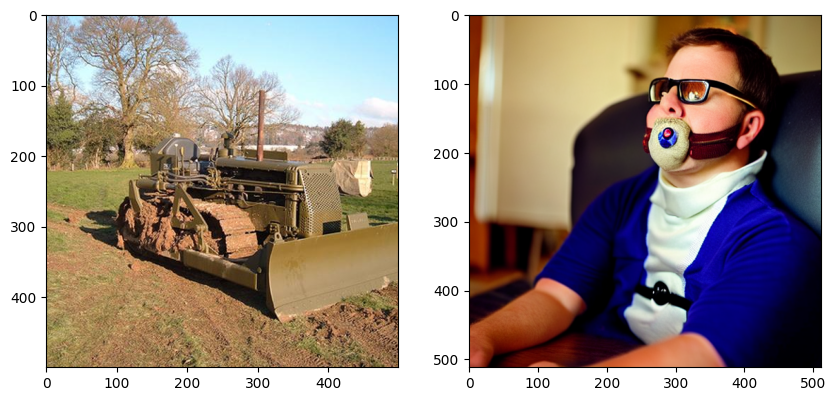

In [165]:
fig,axs=plt.subplots(1,2,figsize=(10,5))
idx=19
axs[0].imshow(np.load(y_test_avg)[idx])
axs[1].imshow(img[idx])


In [144]:
y_test_avg

'god_aligned/GOD_1/y_test_avg.npy'

In [7]:
# x.mean(), x.std()

# brain_decoder.train_fmri_mean.mean(), brain_decoder.train_fmri_std.mean()

In [12]:

test_imgs=[]
generated_imgs=[]

# x,y,c=next(iter(test_dataloader))
i=0
for x,y,c in test_dataloader:
    print(f"{i}/{len(test_dataset)//BS+1}")
    x= (x-brain_decoder.train_fmri_mean)/brain_decoder.train_fmri_std
    x= torch.nan_to_num(x)
    img,gss=brain_decoder.decode(x,scale=False,use_latents=True)
    test_imgs.append(y)
    generated_imgs+=img
    i+=1
    
test_imgs=torch.cat(test_imgs,0)
generated_imgs_numpy=[np.array(i) for i in generated_imgs]

0/13


100%|███████████████████████████████████████████| 77/77 [00:04<00:00, 16.89it/s]


tensor(1.)
[INFO] Final reconstrution 1/32


/home/matteo/anaconda3/envs/deep/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.28it/s]


[INFO] Final reconstrution 2/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.28it/s]


[INFO] Final reconstrution 3/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.25it/s]


[INFO] Final reconstrution 4/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.25it/s]


[INFO] Final reconstrution 5/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.23it/s]


[INFO] Final reconstrution 6/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.21it/s]


[INFO] Final reconstrution 7/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.19it/s]


[INFO] Final reconstrution 8/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.16it/s]


[INFO] Final reconstrution 9/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.18it/s]


[INFO] Final reconstrution 10/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  6.53it/s]


[INFO] Final reconstrution 11/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.16it/s]


[INFO] Final reconstrution 12/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.15it/s]


[INFO] Final reconstrution 13/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.17it/s]


[INFO] Final reconstrution 14/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.18it/s]


[INFO] Final reconstrution 15/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.15it/s]


[INFO] Final reconstrution 16/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.15it/s]


[INFO] Final reconstrution 17/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.15it/s]


[INFO] Final reconstrution 18/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.15it/s]


[INFO] Final reconstrution 19/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.14it/s]


[INFO] Final reconstrution 20/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.14it/s]


[INFO] Final reconstrution 21/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.14it/s]


[INFO] Final reconstrution 22/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.15it/s]


[INFO] Final reconstrution 23/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.14it/s]


[INFO] Final reconstrution 24/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.14it/s]


[INFO] Final reconstrution 25/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.14it/s]


[INFO] Final reconstrution 26/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.14it/s]


[INFO] Final reconstrution 27/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.13it/s]


[INFO] Final reconstrution 28/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.15it/s]


[INFO] Final reconstrution 29/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.14it/s]


[INFO] Final reconstrution 30/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.14it/s]


[INFO] Final reconstrution 31/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.15it/s]


[INFO] Final reconstrution 32/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.16it/s]


1/13


100%|███████████████████████████████████████████| 77/77 [00:30<00:00,  2.54it/s]


tensor(1.)
[INFO] Final reconstrution 1/32


/home/matteo/anaconda3/envs/deep/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.28it/s]


[INFO] Final reconstrution 2/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.25it/s]


[INFO] Final reconstrution 3/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.24it/s]


[INFO] Final reconstrution 4/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.23it/s]


[INFO] Final reconstrution 5/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.21it/s]


[INFO] Final reconstrution 6/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.19it/s]


[INFO] Final reconstrution 7/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.19it/s]


[INFO] Final reconstrution 8/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.18it/s]


[INFO] Final reconstrution 9/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.17it/s]


[INFO] Final reconstrution 10/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.17it/s]


[INFO] Final reconstrution 11/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.17it/s]


[INFO] Final reconstrution 12/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.16it/s]


[INFO] Final reconstrution 13/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.15it/s]


[INFO] Final reconstrution 14/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.15it/s]


[INFO] Final reconstrution 15/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.15it/s]


[INFO] Final reconstrution 16/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.15it/s]


[INFO] Final reconstrution 17/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.15it/s]


[INFO] Final reconstrution 18/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.14it/s]


[INFO] Final reconstrution 19/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.14it/s]


[INFO] Final reconstrution 20/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.15it/s]


[INFO] Final reconstrution 21/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.15it/s]


[INFO] Final reconstrution 22/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.14it/s]


[INFO] Final reconstrution 23/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.14it/s]


[INFO] Final reconstrution 24/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.14it/s]


[INFO] Final reconstrution 25/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.15it/s]


[INFO] Final reconstrution 26/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.15it/s]


[INFO] Final reconstrution 27/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.14it/s]


[INFO] Final reconstrution 28/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.14it/s]


[INFO] Final reconstrution 29/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.15it/s]


[INFO] Final reconstrution 30/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.17it/s]


[INFO] Final reconstrution 31/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.18it/s]


[INFO] Final reconstrution 32/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.17it/s]


2/13


100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 142.23it/s]
/home/matteo/explore_NSD_MNI/vae_helpers.py:164: RuntimeWarning: invalid value encountered in cast
  xhat = np.minimum(np.maximum(0.0, xhat), 255.0).astype(np.uint8)
/home/matteo/anaconda3/envs/deep/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


tensor(1.)
[INFO] Final reconstrution 1/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.27it/s]


[INFO] Final reconstrution 2/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.29it/s]


[INFO] Final reconstrution 3/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.28it/s]


[INFO] Final reconstrution 4/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.26it/s]


[INFO] Final reconstrution 5/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.24it/s]


[INFO] Final reconstrution 6/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.23it/s]


[INFO] Final reconstrution 7/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.21it/s]


[INFO] Final reconstrution 8/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.20it/s]


[INFO] Final reconstrution 9/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.20it/s]


[INFO] Final reconstrution 10/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.20it/s]


[INFO] Final reconstrution 11/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.20it/s]


[INFO] Final reconstrution 12/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.20it/s]


[INFO] Final reconstrution 13/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.20it/s]


[INFO] Final reconstrution 14/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.18it/s]


[INFO] Final reconstrution 15/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.19it/s]


[INFO] Final reconstrution 16/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.19it/s]


[INFO] Final reconstrution 17/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.20it/s]


[INFO] Final reconstrution 18/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.18it/s]


[INFO] Final reconstrution 19/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.18it/s]


[INFO] Final reconstrution 20/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.18it/s]


[INFO] Final reconstrution 21/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.17it/s]


[INFO] Final reconstrution 22/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.14it/s]


[INFO] Final reconstrution 23/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.16it/s]


[INFO] Final reconstrution 24/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.15it/s]


[INFO] Final reconstrution 25/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.16it/s]


[INFO] Final reconstrution 26/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.14it/s]


[INFO] Final reconstrution 27/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.15it/s]


[INFO] Final reconstrution 28/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.14it/s]


[INFO] Final reconstrution 29/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.15it/s]


[INFO] Final reconstrution 30/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.18it/s]


[INFO] Final reconstrution 31/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.18it/s]


[INFO] Final reconstrution 32/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.16it/s]


3/13


100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 163.34it/s]


tensor(1.)
[INFO] Final reconstrution 1/32


/home/matteo/anaconda3/envs/deep/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.20it/s]


[INFO] Final reconstrution 2/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.19it/s]


[INFO] Final reconstrution 3/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.18it/s]


[INFO] Final reconstrution 4/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.17it/s]


[INFO] Final reconstrution 5/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.16it/s]


[INFO] Final reconstrution 6/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.16it/s]


[INFO] Final reconstrution 7/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.15it/s]


[INFO] Final reconstrution 8/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.15it/s]


[INFO] Final reconstrution 9/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.15it/s]


[INFO] Final reconstrution 10/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.14it/s]


[INFO] Final reconstrution 11/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.14it/s]


[INFO] Final reconstrution 12/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.14it/s]


[INFO] Final reconstrution 13/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.14it/s]


[INFO] Final reconstrution 14/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.14it/s]


[INFO] Final reconstrution 15/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.14it/s]


[INFO] Final reconstrution 16/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.14it/s]


[INFO] Final reconstrution 17/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.14it/s]


[INFO] Final reconstrution 18/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.14it/s]


[INFO] Final reconstrution 19/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.14it/s]


[INFO] Final reconstrution 20/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.14it/s]


[INFO] Final reconstrution 21/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.14it/s]


[INFO] Final reconstrution 22/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.14it/s]


[INFO] Final reconstrution 23/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.13it/s]


[INFO] Final reconstrution 24/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.14it/s]


[INFO] Final reconstrution 25/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.15it/s]


[INFO] Final reconstrution 26/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.14it/s]


[INFO] Final reconstrution 27/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.14it/s]


[INFO] Final reconstrution 28/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.14it/s]


[INFO] Final reconstrution 29/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.14it/s]


[INFO] Final reconstrution 30/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.14it/s]


[INFO] Final reconstrution 31/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.14it/s]


[INFO] Final reconstrution 32/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.14it/s]


4/13


100%|███████████████████████████████████████████| 77/77 [00:13<00:00,  5.89it/s]
/home/matteo/explore_NSD_MNI/vae_helpers.py:164: RuntimeWarning: invalid value encountered in cast
  xhat = np.minimum(np.maximum(0.0, xhat), 255.0).astype(np.uint8)
/home/matteo/anaconda3/envs/deep/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


tensor(1.)
[INFO] Final reconstrution 1/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.20it/s]


[INFO] Final reconstrution 2/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.19it/s]


[INFO] Final reconstrution 3/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.20it/s]


[INFO] Final reconstrution 4/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.19it/s]


[INFO] Final reconstrution 5/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.18it/s]


[INFO] Final reconstrution 6/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.18it/s]


[INFO] Final reconstrution 7/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.17it/s]


[INFO] Final reconstrution 8/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.15it/s]


[INFO] Final reconstrution 9/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.15it/s]


[INFO] Final reconstrution 10/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.15it/s]


[INFO] Final reconstrution 11/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.14it/s]


[INFO] Final reconstrution 12/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.14it/s]


[INFO] Final reconstrution 13/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.14it/s]


[INFO] Final reconstrution 14/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.14it/s]


[INFO] Final reconstrution 15/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.14it/s]


[INFO] Final reconstrution 16/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.14it/s]


[INFO] Final reconstrution 17/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.14it/s]


[INFO] Final reconstrution 18/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.16it/s]


[INFO] Final reconstrution 19/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.15it/s]


[INFO] Final reconstrution 20/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.14it/s]


[INFO] Final reconstrution 21/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.14it/s]


[INFO] Final reconstrution 22/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.14it/s]


[INFO] Final reconstrution 23/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.14it/s]


[INFO] Final reconstrution 24/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.15it/s]


[INFO] Final reconstrution 25/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.13it/s]


[INFO] Final reconstrution 26/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.13it/s]


[INFO] Final reconstrution 27/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.14it/s]


[INFO] Final reconstrution 28/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.14it/s]


[INFO] Final reconstrution 29/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.14it/s]


[INFO] Final reconstrution 30/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.14it/s]


[INFO] Final reconstrution 31/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.14it/s]


[INFO] Final reconstrution 32/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.14it/s]


5/13


100%|███████████████████████████████████████████| 77/77 [00:10<00:00,  7.08it/s]


tensor(1.)
[INFO] Final reconstrution 1/32


/home/matteo/anaconda3/envs/deep/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.25it/s]


[INFO] Final reconstrution 2/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.23it/s]


[INFO] Final reconstrution 3/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.23it/s]


[INFO] Final reconstrution 4/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.21it/s]


[INFO] Final reconstrution 5/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.19it/s]


[INFO] Final reconstrution 6/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.20it/s]


[INFO] Final reconstrution 7/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.19it/s]


[INFO] Final reconstrution 8/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.19it/s]


[INFO] Final reconstrution 9/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.18it/s]


[INFO] Final reconstrution 10/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.16it/s]


[INFO] Final reconstrution 11/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.15it/s]


[INFO] Final reconstrution 12/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.15it/s]


[INFO] Final reconstrution 13/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.15it/s]


[INFO] Final reconstrution 14/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.15it/s]


[INFO] Final reconstrution 15/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.15it/s]


[INFO] Final reconstrution 16/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.15it/s]


[INFO] Final reconstrution 17/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.15it/s]


[INFO] Final reconstrution 18/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.14it/s]


[INFO] Final reconstrution 19/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.14it/s]


[INFO] Final reconstrution 20/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.14it/s]


[INFO] Final reconstrution 21/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.14it/s]


[INFO] Final reconstrution 22/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.14it/s]


[INFO] Final reconstrution 23/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.14it/s]


[INFO] Final reconstrution 24/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.14it/s]


[INFO] Final reconstrution 25/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.16it/s]


[INFO] Final reconstrution 26/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.16it/s]


[INFO] Final reconstrution 27/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.16it/s]


[INFO] Final reconstrution 28/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.16it/s]


[INFO] Final reconstrution 29/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.15it/s]


[INFO] Final reconstrution 30/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.15it/s]


[INFO] Final reconstrution 31/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.16it/s]


[INFO] Final reconstrution 32/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.16it/s]


6/13


100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 160.60it/s]
/home/matteo/explore_NSD_MNI/vae_helpers.py:164: RuntimeWarning: invalid value encountered in cast
  xhat = np.minimum(np.maximum(0.0, xhat), 255.0).astype(np.uint8)
/home/matteo/anaconda3/envs/deep/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


tensor(1.)
[INFO] Final reconstrution 1/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.29it/s]


[INFO] Final reconstrution 2/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.27it/s]


[INFO] Final reconstrution 3/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.25it/s]


[INFO] Final reconstrution 4/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.23it/s]


[INFO] Final reconstrution 5/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.23it/s]


[INFO] Final reconstrution 6/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.22it/s]


[INFO] Final reconstrution 7/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.21it/s]


[INFO] Final reconstrution 8/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.21it/s]


[INFO] Final reconstrution 9/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.20it/s]


[INFO] Final reconstrution 10/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.20it/s]


[INFO] Final reconstrution 11/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.19it/s]


[INFO] Final reconstrution 12/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.19it/s]


[INFO] Final reconstrution 13/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.18it/s]


[INFO] Final reconstrution 14/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.18it/s]


[INFO] Final reconstrution 15/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.18it/s]


[INFO] Final reconstrution 16/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.18it/s]


[INFO] Final reconstrution 17/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.18it/s]


[INFO] Final reconstrution 18/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.18it/s]


[INFO] Final reconstrution 19/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.18it/s]


[INFO] Final reconstrution 20/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.18it/s]


[INFO] Final reconstrution 21/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.18it/s]


[INFO] Final reconstrution 22/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.17it/s]


[INFO] Final reconstrution 23/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.18it/s]


[INFO] Final reconstrution 24/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.17it/s]


[INFO] Final reconstrution 25/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.17it/s]


[INFO] Final reconstrution 26/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.17it/s]


[INFO] Final reconstrution 27/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.17it/s]


[INFO] Final reconstrution 28/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.17it/s]


[INFO] Final reconstrution 29/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.17it/s]


[INFO] Final reconstrution 30/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.17it/s]


[INFO] Final reconstrution 31/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.18it/s]


[INFO] Final reconstrution 32/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.17it/s]


7/13


100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 168.87it/s]


tensor(1.)
[INFO] Final reconstrution 1/32


/home/matteo/anaconda3/envs/deep/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.21it/s]


[INFO] Final reconstrution 2/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.21it/s]


[INFO] Final reconstrution 3/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.20it/s]


[INFO] Final reconstrution 4/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.20it/s]


[INFO] Final reconstrution 5/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.19it/s]


[INFO] Final reconstrution 6/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.19it/s]


[INFO] Final reconstrution 7/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.16it/s]


[INFO] Final reconstrution 8/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.15it/s]


[INFO] Final reconstrution 9/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.15it/s]


[INFO] Final reconstrution 10/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.15it/s]


[INFO] Final reconstrution 11/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.15it/s]


[INFO] Final reconstrution 12/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.15it/s]


[INFO] Final reconstrution 13/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.14it/s]


[INFO] Final reconstrution 14/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.14it/s]


[INFO] Final reconstrution 15/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.14it/s]


[INFO] Final reconstrution 16/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.14it/s]


[INFO] Final reconstrution 17/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.14it/s]


[INFO] Final reconstrution 18/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.16it/s]


[INFO] Final reconstrution 19/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.17it/s]


[INFO] Final reconstrution 20/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.16it/s]


[INFO] Final reconstrution 21/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.15it/s]


[INFO] Final reconstrution 22/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.16it/s]


[INFO] Final reconstrution 23/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.15it/s]


[INFO] Final reconstrution 24/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.16it/s]


[INFO] Final reconstrution 25/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.15it/s]


[INFO] Final reconstrution 26/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.15it/s]


[INFO] Final reconstrution 27/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.15it/s]


[INFO] Final reconstrution 28/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.15it/s]


[INFO] Final reconstrution 29/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.15it/s]


[INFO] Final reconstrution 30/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.15it/s]


[INFO] Final reconstrution 31/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.15it/s]


[INFO] Final reconstrution 32/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.15it/s]


8/13


100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 139.62it/s]


tensor(1.)
[INFO] Final reconstrution 1/32


/home/matteo/anaconda3/envs/deep/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.18it/s]


[INFO] Final reconstrution 2/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.19it/s]


[INFO] Final reconstrution 3/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.18it/s]


[INFO] Final reconstrution 4/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.18it/s]


[INFO] Final reconstrution 5/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.16it/s]


[INFO] Final reconstrution 6/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.15it/s]


[INFO] Final reconstrution 7/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.15it/s]


[INFO] Final reconstrution 8/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.15it/s]


[INFO] Final reconstrution 9/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.14it/s]


[INFO] Final reconstrution 10/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.15it/s]


[INFO] Final reconstrution 11/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.16it/s]


[INFO] Final reconstrution 12/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.16it/s]


[INFO] Final reconstrution 13/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.14it/s]


[INFO] Final reconstrution 14/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.14it/s]


[INFO] Final reconstrution 15/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.14it/s]


[INFO] Final reconstrution 16/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.14it/s]


[INFO] Final reconstrution 17/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.14it/s]


[INFO] Final reconstrution 18/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.13it/s]


[INFO] Final reconstrution 19/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.14it/s]


[INFO] Final reconstrution 20/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.14it/s]


[INFO] Final reconstrution 21/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.14it/s]


[INFO] Final reconstrution 22/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.14it/s]


[INFO] Final reconstrution 23/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.14it/s]


[INFO] Final reconstrution 24/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.14it/s]


[INFO] Final reconstrution 25/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.14it/s]


[INFO] Final reconstrution 26/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.13it/s]


[INFO] Final reconstrution 27/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.13it/s]


[INFO] Final reconstrution 28/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.13it/s]


[INFO] Final reconstrution 29/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.13it/s]


[INFO] Final reconstrution 30/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.13it/s]


[INFO] Final reconstrution 31/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.13it/s]


[INFO] Final reconstrution 32/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.14it/s]


9/13


100%|███████████████████████████████████████████| 77/77 [00:21<00:00,  3.66it/s]


tensor(1.)
[INFO] Final reconstrution 1/32


/home/matteo/anaconda3/envs/deep/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.22it/s]


[INFO] Final reconstrution 2/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.20it/s]


[INFO] Final reconstrution 3/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.19it/s]


[INFO] Final reconstrution 4/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.18it/s]


[INFO] Final reconstrution 5/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.18it/s]


[INFO] Final reconstrution 6/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.17it/s]


[INFO] Final reconstrution 7/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.17it/s]


[INFO] Final reconstrution 8/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.16it/s]


[INFO] Final reconstrution 9/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.15it/s]


[INFO] Final reconstrution 10/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.15it/s]


[INFO] Final reconstrution 11/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.15it/s]


[INFO] Final reconstrution 12/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.15it/s]


[INFO] Final reconstrution 13/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.16it/s]


[INFO] Final reconstrution 14/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.15it/s]


[INFO] Final reconstrution 15/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.15it/s]


[INFO] Final reconstrution 16/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.14it/s]


[INFO] Final reconstrution 17/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.14it/s]


[INFO] Final reconstrution 18/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.14it/s]


[INFO] Final reconstrution 19/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.14it/s]


[INFO] Final reconstrution 20/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.14it/s]


[INFO] Final reconstrution 21/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.14it/s]


[INFO] Final reconstrution 22/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.14it/s]


[INFO] Final reconstrution 23/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.14it/s]


[INFO] Final reconstrution 24/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.14it/s]


[INFO] Final reconstrution 25/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.14it/s]


[INFO] Final reconstrution 26/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.13it/s]


[INFO] Final reconstrution 27/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.14it/s]


[INFO] Final reconstrution 28/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.14it/s]


[INFO] Final reconstrution 29/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.15it/s]


[INFO] Final reconstrution 30/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.15it/s]


[INFO] Final reconstrution 31/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.15it/s]


[INFO] Final reconstrution 32/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.14it/s]


10/13


100%|███████████████████████████████████████████| 77/77 [00:03<00:00, 24.16it/s]
/home/matteo/explore_NSD_MNI/vae_helpers.py:164: RuntimeWarning: invalid value encountered in cast
  xhat = np.minimum(np.maximum(0.0, xhat), 255.0).astype(np.uint8)
/home/matteo/anaconda3/envs/deep/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


tensor(1.)
[INFO] Final reconstrution 1/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.26it/s]


[INFO] Final reconstrution 2/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.25it/s]


[INFO] Final reconstrution 3/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.23it/s]


[INFO] Final reconstrution 4/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.23it/s]


[INFO] Final reconstrution 5/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.20it/s]


[INFO] Final reconstrution 6/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.18it/s]


[INFO] Final reconstrution 7/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.18it/s]


[INFO] Final reconstrution 8/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.18it/s]


[INFO] Final reconstrution 9/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.17it/s]


[INFO] Final reconstrution 10/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.17it/s]


[INFO] Final reconstrution 11/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.16it/s]


[INFO] Final reconstrution 12/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.16it/s]


[INFO] Final reconstrution 13/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.16it/s]


[INFO] Final reconstrution 14/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.15it/s]


[INFO] Final reconstrution 15/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.15it/s]


[INFO] Final reconstrution 16/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.15it/s]


[INFO] Final reconstrution 17/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.16it/s]


[INFO] Final reconstrution 18/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.14it/s]


[INFO] Final reconstrution 19/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.14it/s]


[INFO] Final reconstrution 20/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.15it/s]


[INFO] Final reconstrution 21/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.16it/s]


[INFO] Final reconstrution 22/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.16it/s]


[INFO] Final reconstrution 23/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.15it/s]


[INFO] Final reconstrution 24/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.14it/s]


[INFO] Final reconstrution 25/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.14it/s]


[INFO] Final reconstrution 26/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.14it/s]


[INFO] Final reconstrution 27/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.14it/s]


[INFO] Final reconstrution 28/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.14it/s]


[INFO] Final reconstrution 29/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.14it/s]


[INFO] Final reconstrution 30/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.14it/s]


[INFO] Final reconstrution 31/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.14it/s]


[INFO] Final reconstrution 32/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.14it/s]


11/13


100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 151.71it/s]


tensor(1.)


/home/matteo/anaconda3/envs/deep/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


[INFO] Final reconstrution 1/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.23it/s]


[INFO] Final reconstrution 2/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.22it/s]


[INFO] Final reconstrution 3/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.20it/s]


[INFO] Final reconstrution 4/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.20it/s]


[INFO] Final reconstrution 5/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.19it/s]


[INFO] Final reconstrution 6/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.19it/s]


[INFO] Final reconstrution 7/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.19it/s]


[INFO] Final reconstrution 8/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.17it/s]


[INFO] Final reconstrution 9/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.16it/s]


[INFO] Final reconstrution 10/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.15it/s]


[INFO] Final reconstrution 11/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.15it/s]


[INFO] Final reconstrution 12/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.15it/s]


[INFO] Final reconstrution 13/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.17it/s]


[INFO] Final reconstrution 14/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.17it/s]


[INFO] Final reconstrution 15/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.16it/s]


[INFO] Final reconstrution 16/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.16it/s]


[INFO] Final reconstrution 17/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.16it/s]


[INFO] Final reconstrution 18/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.16it/s]


[INFO] Final reconstrution 19/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.16it/s]


[INFO] Final reconstrution 20/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.16it/s]


[INFO] Final reconstrution 21/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.16it/s]


[INFO] Final reconstrution 22/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.16it/s]


[INFO] Final reconstrution 23/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.16it/s]


[INFO] Final reconstrution 24/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.16it/s]


[INFO] Final reconstrution 25/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.16it/s]


[INFO] Final reconstrution 26/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.16it/s]


[INFO] Final reconstrution 27/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.16it/s]


[INFO] Final reconstrution 28/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.16it/s]


[INFO] Final reconstrution 29/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.16it/s]


[INFO] Final reconstrution 30/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.16it/s]


[INFO] Final reconstrution 31/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.16it/s]


[INFO] Final reconstrution 32/32


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.16it/s]


12/13


100%|██████████████████████████████████████████| 77/77 [00:00<00:00, 137.28it/s]
/home/matteo/explore_NSD_MNI/vae_helpers.py:164: RuntimeWarning: invalid value encountered in cast
  xhat = np.minimum(np.maximum(0.0, xhat), 255.0).astype(np.uint8)
/home/matteo/anaconda3/envs/deep/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


tensor(1.)
[INFO] Final reconstrution 1/27


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.21it/s]


[INFO] Final reconstrution 2/27


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.21it/s]


[INFO] Final reconstrution 3/27


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.20it/s]


[INFO] Final reconstrution 4/27


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.19it/s]


[INFO] Final reconstrution 5/27


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.19it/s]


[INFO] Final reconstrution 6/27


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.18it/s]


[INFO] Final reconstrution 7/27


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.18it/s]


[INFO] Final reconstrution 8/27


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.16it/s]


[INFO] Final reconstrution 9/27


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.18it/s]


[INFO] Final reconstrution 10/27


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.19it/s]


[INFO] Final reconstrution 11/27


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.18it/s]


[INFO] Final reconstrution 12/27


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.18it/s]


[INFO] Final reconstrution 13/27


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.18it/s]


[INFO] Final reconstrution 14/27


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.18it/s]


[INFO] Final reconstrution 15/27


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.18it/s]


[INFO] Final reconstrution 16/27


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.18it/s]


[INFO] Final reconstrution 17/27


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.18it/s]


[INFO] Final reconstrution 18/27


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.17it/s]


[INFO] Final reconstrution 19/27


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.17it/s]


[INFO] Final reconstrution 20/27


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.18it/s]


[INFO] Final reconstrution 21/27


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.18it/s]


[INFO] Final reconstrution 22/27


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.18it/s]


[INFO] Final reconstrution 23/27


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.17it/s]


[INFO] Final reconstrution 24/27


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.17it/s]


[INFO] Final reconstrution 25/27


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.17it/s]


[INFO] Final reconstrution 26/27


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.16it/s]


[INFO] Final reconstrution 27/27


100%|███████████████████████████████████████████| 37/37 [00:05<00:00,  7.14it/s]


In [15]:
os.makedirs(f"outputs/{bold_subj}", exist_ok=True)

In [16]:
np.save(f"outputs/{bold_subj}/generated_imgs.npy",np.array(generated_imgs_numpy))
np.save(f"outputs/{bold_subj}/test_imgs.npy",test_imgs.permute(0,2,3,1).numpy())


In [17]:
print("fine")

fine
